# TrainScannerNetwork.ipynb

## Author: Daniel Mallia
## Date Begun: 1/17/2020

**This Jupyter Notebook contains the process for training a Keras network for Optical Character Recognition (OCR) for use with a document scanner app, on the Chars74K Dataset. See the following citation and link for the dataset:**

T. E. de Campos, B. R. Babu and M. Varma. Character recognition in natural images. In Proceedings of the International Conference on Computer Vision Theory and Applications (VISAPP), Lisbon, Portugal, February 2009. 


http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

In [29]:
# Imports
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from numpy.random import default_rng
import os
import shutil
import math
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv

## Organize Data:

For now, training will only be done on the "Fnt" folder, which contains computer font characters, of 4 different variations. This data comes as a single folder with a directory for each class - thus we must split into train/test file sets before using a validation split on the training data generator.

Inspiration from how to handle this in part from here: 
https://stackoverflow.com/questions/46717742/split-data-directory-into-training-and-test-directory-with-sub-directory-structu

and 

https://stackoverflow.com/questions/8505651/non-repetitive-random-number-in-numpy

In [3]:
# trainDataLocation = '/Users/danielmallia/Documents/TTP/IndependentStudy/Capstone/Data/English/Fnt/'
# testDataLocation = '/Users/danielmallia/Documents/TTP/IndependentStudy/Capstone/Data/English/FntTest/'

# # For each sample folder
# for folder in os.listdir(trainDataLocation):
#     if(folder == '.DS_Store'): # Ignore .DS_Store files
#         continue
#     else: 
#         # Make a matching test folder
#         testPath = testDataLocation + folder + '/'
#         os.mkdir(testPath)
        
#         currentFolderPath = trainDataLocation + folder + '/'
#         FILE_NAME_LIST = os.listdir(currentFolderPath)
#         numberOfFiles = len(FILE_NAME_LIST)
#         numRange = np.arange(0, numberOfFiles)
#         numOfSelections = math.floor(numberOfFiles * .2)
        
#         # Randomly select indices for choosing approximately 20% of the samples
#         randomNumGen = default_rng()
#         testSelections = randomNumGen.choice(numRange, size=numOfSelections, replace=False)
        
#         # For each index selected
#         for index in testSelections:
#             filename = FILE_NAME_LIST[index]
#             shutil.move(currentFolderPath + filename, testPath + filename)

## Data Preprocessing:

**NOT DOING DATA AUGMENTATION BECAUSE OTHERWISE THIS WILL ALSO BE APPLIED TO THE VALIDATION DATA.
THIS IS A KNOWN ISSUE WITH KERAS, SEE:**

https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in

This is useful for understanding how to do the train/validation split: https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

Useful for understanding the matter of class labels with Keras: https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

In [10]:
trainDataLocation = '/Users/danielmallia/Documents/TTP/IndependentStudy/Capstone/Data/English/Fnt/'
testDataLocation = '/Users/danielmallia/Documents/TTP/IndependentStudy/Capstone/Data/English/FntTest/'

imageSize = (128, 128) # Chars 74k image size

# Initialize generators - just appropriate scaling and validation split
trainDataGen = ImageDataGenerator(rescale=1./255, validation_split=.2)
testDataGen = ImageDataGenerator(rescale=1./255)

# Flow from directories

trainGenerator = trainDataGen.flow_from_directory(trainDataLocation,
                             target_size=imageSize,
                             class_mode="categorical",
                             subset="training")

validationGenerator = trainDataGen.flow_from_directory(trainDataLocation,
                                  target_size=imageSize,
                                  class_mode="categorical",
                                  subset="validation")

testGenerator = testDataGen.flow_from_directory(testDataLocation,
                           target_size=imageSize,
                           class_mode="categorical")

Found 40362 images belonging to 62 classes.
Found 10044 images belonging to 62 classes.
Found 12586 images belonging to 62 classes.


In [11]:
classLabels = []

for i in range(0, 10):
    classLabels.append(str(i))
for i in range(ord('A'), ord('Z') + 1):
    classLabels.append(chr(i))
for i in range(ord('a'), ord('z') + 1):
    classLabels.append(chr(i))
    
print(classLabels)
print(len(classLabels))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
62


In [12]:
# Generate mapping dictionary
#print(trainGenerator.class_indices)

i = 0
mapping = {}
for key in trainGenerator.class_indices:
    #print(trainGenerator.class_indices[key])
    mapping[key] = classLabels[i]
    i+=1
    
print(mapping)

{'Sample001': '0', 'Sample002': '1', 'Sample003': '2', 'Sample004': '3', 'Sample005': '4', 'Sample006': '5', 'Sample007': '6', 'Sample008': '7', 'Sample009': '8', 'Sample010': '9', 'Sample011': 'A', 'Sample012': 'B', 'Sample013': 'C', 'Sample014': 'D', 'Sample015': 'E', 'Sample016': 'F', 'Sample017': 'G', 'Sample018': 'H', 'Sample019': 'I', 'Sample020': 'J', 'Sample021': 'K', 'Sample022': 'L', 'Sample023': 'M', 'Sample024': 'N', 'Sample025': 'O', 'Sample026': 'P', 'Sample027': 'Q', 'Sample028': 'R', 'Sample029': 'S', 'Sample030': 'T', 'Sample031': 'U', 'Sample032': 'V', 'Sample033': 'W', 'Sample034': 'X', 'Sample035': 'Y', 'Sample036': 'Z', 'Sample037': 'a', 'Sample038': 'b', 'Sample039': 'c', 'Sample040': 'd', 'Sample041': 'e', 'Sample042': 'f', 'Sample043': 'g', 'Sample044': 'h', 'Sample045': 'i', 'Sample046': 'j', 'Sample047': 'k', 'Sample048': 'l', 'Sample049': 'm', 'Sample050': 'n', 'Sample051': 'o', 'Sample052': 'p', 'Sample053': 'q', 'Sample054': 'r', 'Sample055': 's', 'Sample05

## Model:

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3))) # height, width, channels
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)       

In [15]:
numOfTrainingFiles = len(trainGenerator.filepaths)
numOfValidationFiles = len(validationGenerator.filepaths)
batchSize = 64

trainSteps = math.ceil(numOfTrainingFiles / batchSize)
validationSteps = math.ceil(numOfValidationFiles / batchSize)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

trainAndValidationHistory = model.fit_generator(
        trainGenerator,
        steps_per_epoch=trainSteps,
        epochs=5,
        validation_data=validationGenerator,
        validation_steps=validationSteps)

Epoch 1/5
631/631 [==============================] - 108s 171ms/step - loss: 1.1588 - accuracy: 0.6935 - val_loss: 0.5141 - val_accuracy: 0.8207
Epoch 2/5
631/631 [==============================] - 106s 167ms/step - loss: 0.5197 - accuracy: 0.8323 - val_loss: 0.2159 - val_accuracy: 0.8526
Epoch 3/5
631/631 [==============================] - 106s 168ms/step - loss: 0.3805 - accuracy: 0.8652 - val_loss: 0.6513 - val_accuracy: 0.8525
Epoch 4/5
631/631 [==============================] - 106s 168ms/step - loss: 0.3503 - accuracy: 0.8753 - val_loss: 0.7089 - val_accuracy: 0.8637
Epoch 5/5
631/631 [==============================] - 105s 166ms/step - loss: 0.2718 - accuracy: 0.8977 - val_loss: 0.6559 - val_accuracy: 0.8680


## Plot Training and Validation Performance:
Uses the same plotting method demonstrated in Deep Learning with Python by Francois Chollet.

### Plot Loss

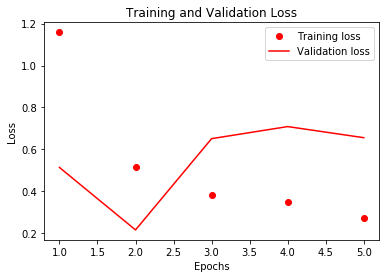

In [16]:
historyDictionary = trainAndValidationHistory.history
lossValues = historyDictionary['loss'] # Extract loss values
validationLossValues = historyDictionary['val_loss'] # Extract validation loss values

epochs = range(1, len(lossValues) + 1)  # Number of epochs

plt.plot(epochs, lossValues, 'ro', label='Training loss') # ro = red circle
plt.plot(epochs, validationLossValues, '-r', label='Validation loss') # -r = red line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Accuracy

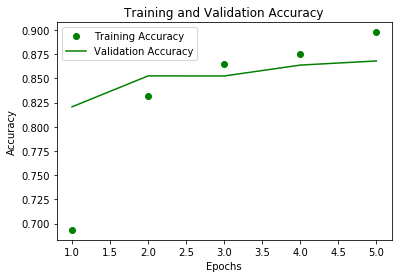

In [19]:
plt.clf() # Clears figure
accuracy = historyDictionary['accuracy']
validationAccuracy = historyDictionary['val_accuracy']

plt.plot(epochs, accuracy, 'go', label='Training Accuracy') # go = green circle
plt.plot(epochs, validationAccuracy, '-g', label='Validation Accuracy') # -g = green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Notes:
#### Model Version 1:

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3))) # height, width, channels
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))

Total params: 368,606
Trainable params: 368,606
Non-trainable params: 0

Achieves an accuracy of mid 80s on training and validation data. Overfits after 2 epochs. A good start but room for improvement. May try increasing the size of the hidden layers. Can also consider data augmentation, but this would require manual splitting of a validation set off the training set, so that augmentation can be done on the training files alone. Waiting to see prediction output before committing to this.

After further reflection - increasing the size of the Dense layer may also be significant. Dropout and padding may also be useful.

#### Model Version 2:



## Prediction Example:

In [45]:
# Read image
predictionTestImage = cv.imread('f.PNG', cv.IMREAD_COLOR)
print('Original image shape: ', predictionTestImage.shape)

# Defining a preprocessing function for later use in main script
def processImage(image):
    output = cv.resize(image, (128, 128), interpolation = cv.INTER_LINEAR) # Resize - may want to try cv.INTER_AREA
    output = output.astype('float32') / 255 # Scale (normalize) to match network training
    output = np.expand_dims(output, axis=0) # Reshape as a 4D tensor for input to network
    
    return output

preparedImage = processImage(predictionTestImage)
print('Processed Image Shape: ', preparedImage.shape)


results = model.predict(preparedImage)
print('Classified image as: ', classLabels[np.argmax(results)])

Original image shape:  (309, 200, 3)
Processed Image Shape:  (1, 128, 128, 3)
Classified image as:  T


## Test:

In [ ]:
numOfTestFiles = len(testGenerator.filepaths)
batchSize = 64

model.evaluate_generator(testGenerator)

## Save Model:

In [8]:
model.save('OCRNetwork.h5')